Supervised Learning 


In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [6]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


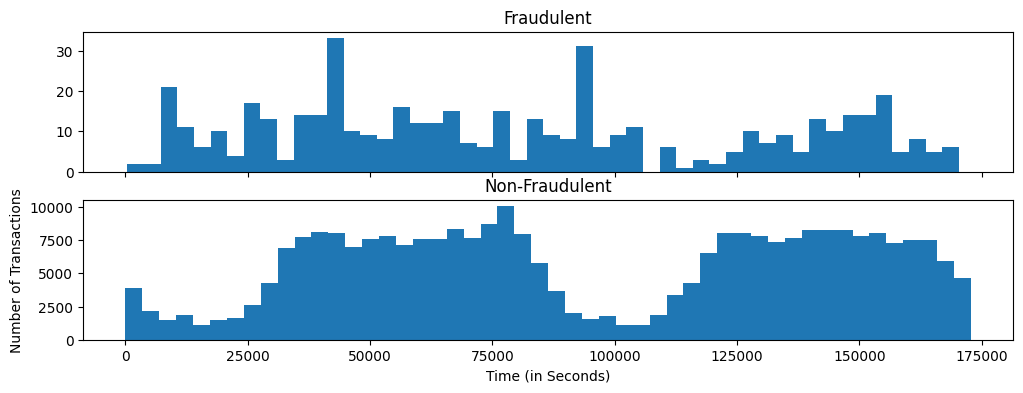

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Time[df.Class == 1], bins = 50)
ax1.set_title("Fraudulent")
ax2.hist(df.Time[df.Class == 0], bins = 50)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

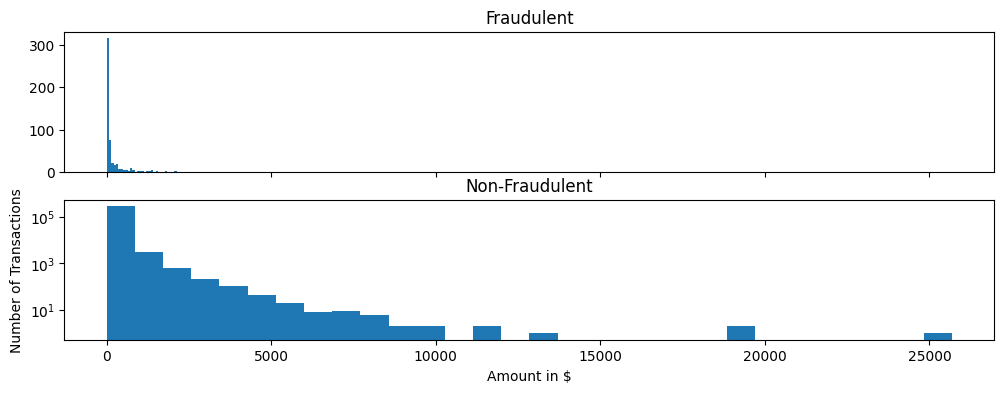

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex = True, figsize = [12,4])

ax1.hist(df.Amount[df.Class == 1], bins = 30)
ax1.set_title("Fraudulent")
ax2.hist(df.Amount[df.Class == 0], bins = 30)
ax2.set_title("Non-Fraudulent")

plt.xlabel('Amount in $')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

Amount variable is skewed. So we will standardize it with mean = 0 and sd = 1.

In [9]:
df["Normalized_Amount"] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
#Drop time & amount variable
df = df.drop(['Time', 'Amount'], axis = 1)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Normalized_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [10]:
Class = [len(df.loc[df.Class == 1]), len(df.loc[df.Class == 0])]
pd.Series(Class, index = ['Fraudulent', 'Non-fraudulent'], name = 'target')

Fraudulent           492
Non-fraudulent    284315
Name: target, dtype: int64

In [11]:
#Percentage of minority(fraudulent) class
print('% of Fraudulent Class = {:.3f}%'.format(len(df[df.Class == 1])*100 / len(df)))

% of Fraudulent Class = 0.173%


In [12]:
def results(balancing_technique):
    print(balancing_technique)
    fig, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6))
    model_name = ["RF", "XGB", "LGB"]
    RFC = RandomForestClassifier(random_state = 0)
    XGBC = XGBClassifier(random_state = 0)
    LGBC = LGBMClassifier(random_state = 0)

    for clf,i in zip([RFC, XGBC, LGBC], model_name):
        model = clf.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:,1]
        print("#"*25,i,"#"*25)
        print("Training Accuracy = {:.3f}".format(model.score(X_train, y_train)))
        print("Test Accuracy = {:.3f}".format(model.score(X_test, y_test)))
        print("ROC_AUC_score : %.6f" % (roc_auc_score(y_test, y_pred)))
        #Confusion Matrix
        print(confusion_matrix(y_test, y_pred))
        print("-"*15,"CLASSIFICATION REPORT","-"*15)
        print(classification_report(y_test, y_pred))
        
        #precision-recall curve
        precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
        avg_pre = average_precision_score(y_test, y_pred_prob)
        ax1.plot(precision, recall, label = i+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
        ax1.set_xlabel('Precision', fontsize = 14)
        ax1.set_ylabel('Recall', fontsize = 14)
        ax1.set_title('Precision-Recall Curve', fontsize = 18)
        ax1.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_pr - 0.5))
        ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

        #roc-curve
        fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr,tpr)
        ax2.plot(fpr,tpr, label = i+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
        ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
        ax2.set_xlabel("False Positive Rate", fontsize = 14)
        ax2.set_ylabel("True Positive Rate", fontsize = 14)
        ax2.set_title("ROC Curve", fontsize = 18)
        ax2.legend(loc = 'best')
        #find default threshold
        close_default = np.argmin(np.abs(thresholds_roc - 0.5))
        ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
        plt.tight_layout()

In [13]:
X = df.drop(columns = 'Class')
y = df['Class']
#Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

Without Balancing
######################### RF #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.880911
[[85289     7]
 [   35   112]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.94      0.76      0.84       147

    accuracy                           1.00     85443
   macro avg       0.97      0.88      0.92     85443
weighted avg       1.00      1.00      1.00     85443

######################### XGB #########################
Training Accuracy = 1.000
Test Accuracy = 1.000
ROC_AUC_score : 0.891110
[[85288     8]
 [   32   115]]
--------------- CLASSIFICATION REPORT ---------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.93      0.78      0.85       147

    accuracy                           1.00     85443
   macro a

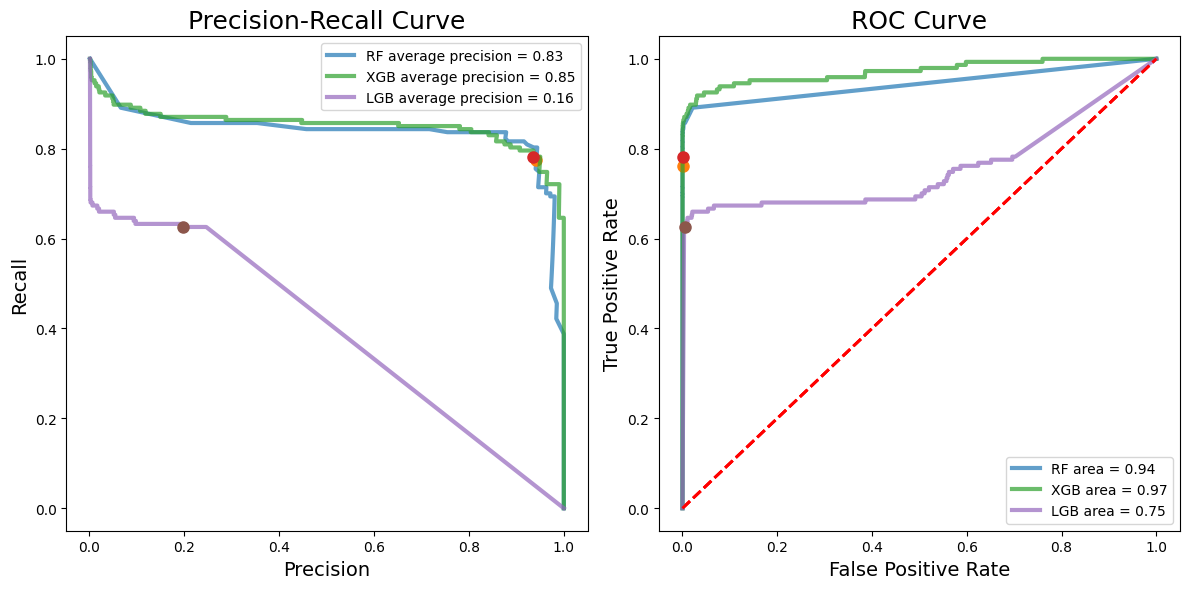

In [14]:
results("Without Balancing")